# Analysis of 77084 zip code using Facebook Prophet

In [ ]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
logging.disable(sys.maxsize)
from fbprophet.diagnostics import cross_validation

In [3]:
df=pd.read_csv('df_zillow_77036_prepped_fbprophet.csv')

<AxesSubplot:>

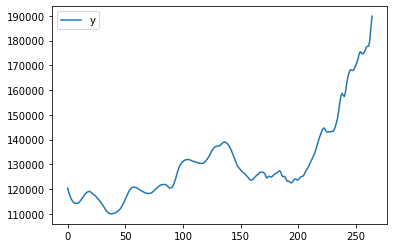

In [4]:
df.plot()

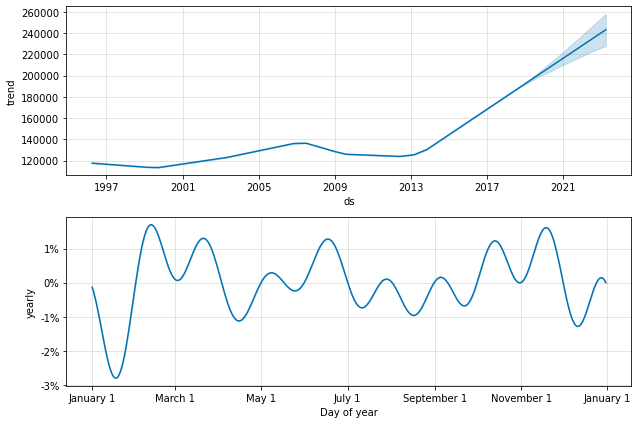

In [5]:
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=60, freq='M')
fcst = m.predict(future)
fig = m.plot_components(fcst)

In [6]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
320,2022-11-30,239752.377357,225408.221219,253766.386961
321,2022-12-31,240330.026404,225381.496877,254907.691388
322,2023-01-31,240351.701164,224772.555850,254751.237841
323,2023-02-28,242589.706862,226938.913678,257350.340794
324,2023-03-31,244430.805296,228192.264909,259275.211244


In [7]:
cutoffs = pd.date_range(start='1996-04', end='2008-04', freq='1MS')
cutoffs

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01', '2008-01-01', '2008-02-01',
               '2008-03-01', '2008-04-01'],
              dtype='datetime64[ns]', length=145, freq='MS')

In [9]:
cv_results = cross_validation( model = m, initial = pd.to_timedelta(5475, unit="d"), horizon = pd.to_timedelta(1825,unit="d"))

In [10]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-05-01,124078.692589,121562.597380,126688.894927,125800.0,2013-04-02
1,2013-06-01,123966.255165,121390.443697,126411.022823,126800.0,2013-04-02
2,2013-07-01,123865.109009,121282.488238,126527.756409,127600.0,2013-04-02
3,2013-08-01,123835.806507,121298.718314,126126.294259,128300.0,2013-04-02
4,2013-09-01,123800.482176,121261.359184,126470.467634,129200.0,2013-04-02


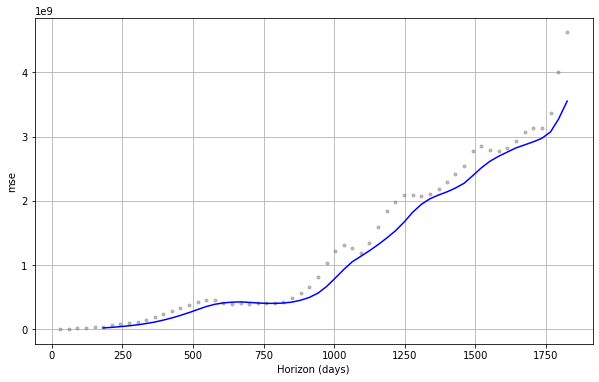

In [14]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mse')